# Simple Models

## Load Data

In [58]:
import pandas as pd

In [59]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [60]:
cat_cols = [x for x in train.columns if x.startswith('cat')]
cat_cols

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'cat10',
 'cat11',
 'cat12',
 'cat13',
 'cat14',
 'cat15',
 'cat16',
 'cat17',
 'cat18']

In [73]:
cont_cols = [x for x in train.columns if x.startswith('cont')]
cont_cols

['cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10']

In [61]:
x_train = train.drop(columns=['id','target'])
x_test = test.drop(columns=['id'])
y_train = train['target']

In [62]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

## Submit

In [63]:
def submit(model, refit = True):
    if refit:
        model.fit(x_train, y_train)
    pred = model.predict_proba(test.drop(columns='id'))[:,1]
    submission = pd.DataFrame({'id':test['id'], 'target':pred})
    return submission

## Default Lightgbm Model

In [25]:
from categorical_transform import CategoricalTransform
from lightgbm.sklearn import LGBMClassifier
from sklearn.pipeline import Pipeline

In [26]:
lightgbm_pipe = Pipeline([("trans", CategoricalTransform(cat_cols)),
                          ("lgbm", LGBMClassifier(n_jobs = -2))])

In [9]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lightgbm_pipe, X=x_train, y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

In [10]:
scores

{'fit_time': array([2.15650249, 2.07859039, 2.09163213, 2.17312503, 2.00976348]),
 'score_time': array([0.22386575, 0.22433829, 0.22683835, 0.22375202, 0.22663021]),
 'test_score': array([0.89309693, 0.89263887, 0.89181025, 0.89258043, 0.88641593]),
 'train_score': array([0.9051304 , 0.9054582 , 0.90564244, 0.90513582, 0.90662625])}

In [11]:
scores['test_score'].mean()

0.8913084816522503

In [27]:
lightgbm_pipe.fit(x_train, y_train)

Pipeline(steps=[('trans',
                 CategoricalTransform(cat_cols=['cat0', 'cat1', 'cat2', 'cat3',
                                                'cat4', 'cat5', 'cat6', 'cat7',
                                                'cat8', 'cat9', 'cat10',
                                                'cat11', 'cat12', 'cat13',
                                                'cat14', 'cat15', 'cat16',
                                                'cat17', 'cat18'])),
                ('lgbm', LGBMClassifier(n_jobs=-2))])

In [28]:
import shap
explainer = shap.TreeExplainer(lightgbm_pipe.named_steps['lgbm'])
shap_values = explainer.shap_values(lightgbm_pipe.named_steps['trans'].transform(x_test))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


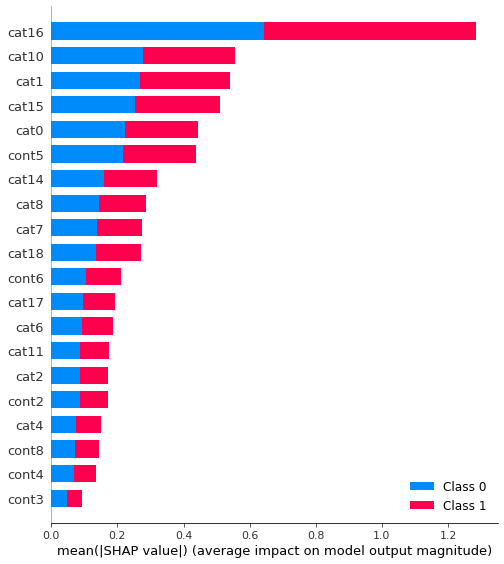

In [29]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [12]:
submission = submit(lightgbm_pipe)
submission.head()

,id,target
0,5,0.140532
1,6,0.368300
2,8,0.030049
3,9,0.177666
4,11,0.112767


In [ ]:
submission.to_csv('submission_lightgbm_default.csv', index=False)

## Default CatBoost

In [7]:
from categorical_transform import IntegerCategoricalTransform
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

In [8]:
cbc = CatBoostClassifier(cat_features=cat_cols, thread_count=6)
catboost_pipe = Pipeline([("trans", IntegerCategoricalTransform(cat_cols)),
                          ("catboost", cbc)])

In [14]:
from sklearn.model_selection import cross_validate
scores = cross_validate(catboost_pipe, X=x_train, y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

Learning rate set to 0.106975
0:	learn: 0.6232939	total: 276ms	remaining: 4m 36s
1:	learn: 0.5695907	total: 482ms	remaining: 4m
2:	learn: 0.5266821	total: 694ms	remaining: 3m 50s
3:	learn: 0.4952912	total: 882ms	remaining: 3m 39s
4:	learn: 0.4709140	total: 1.07s	remaining: 3m 32s
5:	learn: 0.4511241	total: 1.28s	remaining: 3m 31s
6:	learn: 0.4362598	total: 1.48s	remaining: 3m 30s
7:	learn: 0.4247838	total: 1.65s	remaining: 3m 25s
8:	learn: 0.4163111	total: 1.85s	remaining: 3m 23s
9:	learn: 0.4083364	total: 2.04s	remaining: 3m 21s
10:	learn: 0.4019723	total: 2.2s	remaining: 3m 18s
11:	learn: 0.3967994	total: 2.42s	remaining: 3m 19s
12:	learn: 0.3924067	total: 2.63s	remaining: 3m 19s
13:	learn: 0.3886177	total: 2.85s	remaining: 3m 20s
14:	learn: 0.3852989	total: 3.06s	remaining: 3m 20s
15:	learn: 0.3825180	total: 3.28s	remaining: 3m 21s
16:	learn: 0.3804014	total: 3.5s	remaining: 3m 22s
17:	learn: 0.3782656	total: 3.68s	remaining: 3m 20s
18:	learn: 0.3763079	total: 3.88s	remaining: 3m 20

158:	learn: 0.3467556	total: 34.5s	remaining: 3m 2s
159:	learn: 0.3466908	total: 34.8s	remaining: 3m 2s
160:	learn: 0.3466010	total: 35s	remaining: 3m 2s
161:	learn: 0.3465047	total: 35.2s	remaining: 3m 2s
162:	learn: 0.3464603	total: 35.4s	remaining: 3m 1s
163:	learn: 0.3464189	total: 35.7s	remaining: 3m 1s
164:	learn: 0.3463285	total: 35.9s	remaining: 3m 1s
165:	learn: 0.3462827	total: 36.1s	remaining: 3m 1s
166:	learn: 0.3461949	total: 36.3s	remaining: 3m 1s
167:	learn: 0.3461003	total: 36.5s	remaining: 3m
168:	learn: 0.3460331	total: 36.7s	remaining: 3m
169:	learn: 0.3459377	total: 37s	remaining: 3m
170:	learn: 0.3458728	total: 37.2s	remaining: 3m
171:	learn: 0.3457695	total: 37.4s	remaining: 2m 59s
172:	learn: 0.3457173	total: 37.6s	remaining: 2m 59s
173:	learn: 0.3456674	total: 37.9s	remaining: 2m 59s
174:	learn: 0.3456202	total: 38.1s	remaining: 2m 59s
175:	learn: 0.3455634	total: 38.3s	remaining: 2m 59s
176:	learn: 0.3454790	total: 38.5s	remaining: 2m 59s
177:	learn: 0.3454186	

314:	learn: 0.3386220	total: 1m 8s	remaining: 2m 29s
315:	learn: 0.3385704	total: 1m 9s	remaining: 2m 29s
316:	learn: 0.3385511	total: 1m 9s	remaining: 2m 29s
317:	learn: 0.3385162	total: 1m 9s	remaining: 2m 29s
318:	learn: 0.3384797	total: 1m 9s	remaining: 2m 29s
319:	learn: 0.3384551	total: 1m 10s	remaining: 2m 28s
320:	learn: 0.3384325	total: 1m 10s	remaining: 2m 28s
321:	learn: 0.3384081	total: 1m 10s	remaining: 2m 28s
322:	learn: 0.3383764	total: 1m 10s	remaining: 2m 28s
323:	learn: 0.3383063	total: 1m 10s	remaining: 2m 28s
324:	learn: 0.3382811	total: 1m 11s	remaining: 2m 27s
325:	learn: 0.3382609	total: 1m 11s	remaining: 2m 27s
326:	learn: 0.3382023	total: 1m 11s	remaining: 2m 27s
327:	learn: 0.3381644	total: 1m 11s	remaining: 2m 27s
328:	learn: 0.3381263	total: 1m 12s	remaining: 2m 26s
329:	learn: 0.3380514	total: 1m 12s	remaining: 2m 26s
330:	learn: 0.3380179	total: 1m 12s	remaining: 2m 26s
331:	learn: 0.3379891	total: 1m 12s	remaining: 2m 26s
332:	learn: 0.3379487	total: 1m 1

467:	learn: 0.3331802	total: 1m 43s	remaining: 1m 57s
468:	learn: 0.3331291	total: 1m 43s	remaining: 1m 57s
469:	learn: 0.3331120	total: 1m 43s	remaining: 1m 56s
470:	learn: 0.3330521	total: 1m 43s	remaining: 1m 56s
471:	learn: 0.3330193	total: 1m 44s	remaining: 1m 56s
472:	learn: 0.3329652	total: 1m 44s	remaining: 1m 56s
473:	learn: 0.3329370	total: 1m 44s	remaining: 1m 55s
474:	learn: 0.3329088	total: 1m 44s	remaining: 1m 55s
475:	learn: 0.3328553	total: 1m 44s	remaining: 1m 55s
476:	learn: 0.3328155	total: 1m 45s	remaining: 1m 55s
477:	learn: 0.3327468	total: 1m 45s	remaining: 1m 55s
478:	learn: 0.3327059	total: 1m 45s	remaining: 1m 54s
479:	learn: 0.3326819	total: 1m 45s	remaining: 1m 54s
480:	learn: 0.3326394	total: 1m 46s	remaining: 1m 54s
481:	learn: 0.3326065	total: 1m 46s	remaining: 1m 54s
482:	learn: 0.3325752	total: 1m 46s	remaining: 1m 53s
483:	learn: 0.3325463	total: 1m 46s	remaining: 1m 53s
484:	learn: 0.3325034	total: 1m 46s	remaining: 1m 53s
485:	learn: 0.3324860	total:

621:	learn: 0.3284694	total: 2m 17s	remaining: 1m 23s
622:	learn: 0.3284218	total: 2m 17s	remaining: 1m 23s
623:	learn: 0.3283906	total: 2m 17s	remaining: 1m 23s
624:	learn: 0.3283713	total: 2m 18s	remaining: 1m 22s
625:	learn: 0.3283475	total: 2m 18s	remaining: 1m 22s
626:	learn: 0.3283310	total: 2m 18s	remaining: 1m 22s
627:	learn: 0.3283063	total: 2m 18s	remaining: 1m 22s
628:	learn: 0.3282877	total: 2m 18s	remaining: 1m 21s
629:	learn: 0.3282679	total: 2m 19s	remaining: 1m 21s
630:	learn: 0.3282327	total: 2m 19s	remaining: 1m 21s
631:	learn: 0.3281968	total: 2m 19s	remaining: 1m 21s
632:	learn: 0.3281792	total: 2m 19s	remaining: 1m 21s
633:	learn: 0.3281618	total: 2m 20s	remaining: 1m 20s
634:	learn: 0.3281083	total: 2m 20s	remaining: 1m 20s
635:	learn: 0.3280953	total: 2m 20s	remaining: 1m 20s
636:	learn: 0.3280730	total: 2m 20s	remaining: 1m 20s
637:	learn: 0.3280431	total: 2m 20s	remaining: 1m 19s
638:	learn: 0.3280019	total: 2m 21s	remaining: 1m 19s
639:	learn: 0.3279675	total:

775:	learn: 0.3244590	total: 2m 51s	remaining: 49.5s
776:	learn: 0.3244385	total: 2m 51s	remaining: 49.2s
777:	learn: 0.3244157	total: 2m 51s	remaining: 49s
778:	learn: 0.3243917	total: 2m 52s	remaining: 48.8s
779:	learn: 0.3243646	total: 2m 52s	remaining: 48.6s
780:	learn: 0.3243239	total: 2m 52s	remaining: 48.4s
781:	learn: 0.3243006	total: 2m 52s	remaining: 48.2s
782:	learn: 0.3242816	total: 2m 52s	remaining: 47.9s
783:	learn: 0.3242686	total: 2m 53s	remaining: 47.7s
784:	learn: 0.3242530	total: 2m 53s	remaining: 47.5s
785:	learn: 0.3242431	total: 2m 53s	remaining: 47.3s
786:	learn: 0.3242254	total: 2m 53s	remaining: 47.1s
787:	learn: 0.3241951	total: 2m 54s	remaining: 46.9s
788:	learn: 0.3241765	total: 2m 54s	remaining: 46.6s
789:	learn: 0.3241569	total: 2m 54s	remaining: 46.4s
790:	learn: 0.3241374	total: 2m 54s	remaining: 46.2s
791:	learn: 0.3241180	total: 2m 55s	remaining: 46s
792:	learn: 0.3240859	total: 2m 55s	remaining: 45.8s
793:	learn: 0.3240709	total: 2m 55s	remaining: 45.

932:	learn: 0.3206391	total: 3m 26s	remaining: 14.8s
933:	learn: 0.3206164	total: 3m 27s	remaining: 14.6s
934:	learn: 0.3205992	total: 3m 27s	remaining: 14.4s
935:	learn: 0.3205803	total: 3m 27s	remaining: 14.2s
936:	learn: 0.3205638	total: 3m 27s	remaining: 14s
937:	learn: 0.3205489	total: 3m 27s	remaining: 13.7s
938:	learn: 0.3205380	total: 3m 28s	remaining: 13.5s
939:	learn: 0.3204990	total: 3m 28s	remaining: 13.3s
940:	learn: 0.3204791	total: 3m 28s	remaining: 13.1s
941:	learn: 0.3204437	total: 3m 28s	remaining: 12.9s
942:	learn: 0.3204173	total: 3m 29s	remaining: 12.6s
943:	learn: 0.3203910	total: 3m 29s	remaining: 12.4s
944:	learn: 0.3203841	total: 3m 29s	remaining: 12.2s
945:	learn: 0.3203681	total: 3m 29s	remaining: 12s
946:	learn: 0.3203417	total: 3m 29s	remaining: 11.7s
947:	learn: 0.3203097	total: 3m 30s	remaining: 11.5s
948:	learn: 0.3202706	total: 3m 30s	remaining: 11.3s
949:	learn: 0.3202400	total: 3m 30s	remaining: 11.1s
950:	learn: 0.3202248	total: 3m 30s	remaining: 10.

89:	learn: 0.3537394	total: 19.5s	remaining: 3m 16s
90:	learn: 0.3536534	total: 19.7s	remaining: 3m 16s
91:	learn: 0.3535937	total: 19.9s	remaining: 3m 16s
92:	learn: 0.3534915	total: 20.1s	remaining: 3m 15s
93:	learn: 0.3534050	total: 20.3s	remaining: 3m 15s
94:	learn: 0.3533301	total: 20.5s	remaining: 3m 15s
95:	learn: 0.3532250	total: 20.8s	remaining: 3m 15s
96:	learn: 0.3531428	total: 21s	remaining: 3m 15s
97:	learn: 0.3530622	total: 21.2s	remaining: 3m 15s
98:	learn: 0.3529360	total: 21.4s	remaining: 3m 14s
99:	learn: 0.3528352	total: 21.6s	remaining: 3m 14s
100:	learn: 0.3527704	total: 21.8s	remaining: 3m 14s
101:	learn: 0.3526925	total: 22s	remaining: 3m 14s
102:	learn: 0.3525873	total: 22.2s	remaining: 3m 13s
103:	learn: 0.3524907	total: 22.5s	remaining: 3m 13s
104:	learn: 0.3523826	total: 22.7s	remaining: 3m 13s
105:	learn: 0.3522711	total: 22.9s	remaining: 3m 13s
106:	learn: 0.3521564	total: 23.1s	remaining: 3m 12s
107:	learn: 0.3520632	total: 23.3s	remaining: 3m 12s
108:	lea

246:	learn: 0.3422122	total: 54.2s	remaining: 2m 45s
247:	learn: 0.3421579	total: 54.4s	remaining: 2m 44s
248:	learn: 0.3421079	total: 54.6s	remaining: 2m 44s
249:	learn: 0.3420498	total: 54.9s	remaining: 2m 44s
250:	learn: 0.3419964	total: 55.1s	remaining: 2m 44s
251:	learn: 0.3419618	total: 55.3s	remaining: 2m 44s
252:	learn: 0.3419173	total: 55.5s	remaining: 2m 43s
253:	learn: 0.3418871	total: 55.7s	remaining: 2m 43s
254:	learn: 0.3418299	total: 56s	remaining: 2m 43s
255:	learn: 0.3417696	total: 56.2s	remaining: 2m 43s
256:	learn: 0.3417137	total: 56.4s	remaining: 2m 43s
257:	learn: 0.3416882	total: 56.7s	remaining: 2m 43s
258:	learn: 0.3416145	total: 56.9s	remaining: 2m 42s
259:	learn: 0.3416127	total: 57.1s	remaining: 2m 42s
260:	learn: 0.3415413	total: 57.4s	remaining: 2m 42s
261:	learn: 0.3415412	total: 57.6s	remaining: 2m 42s
262:	learn: 0.3414913	total: 57.8s	remaining: 2m 41s
263:	learn: 0.3414502	total: 58s	remaining: 2m 41s
264:	learn: 0.3414264	total: 58.2s	remaining: 2m 4

400:	learn: 0.3361646	total: 1m 28s	remaining: 2m 12s
401:	learn: 0.3361471	total: 1m 28s	remaining: 2m 11s
402:	learn: 0.3361099	total: 1m 28s	remaining: 2m 11s
403:	learn: 0.3360494	total: 1m 29s	remaining: 2m 11s
404:	learn: 0.3360355	total: 1m 29s	remaining: 2m 11s
405:	learn: 0.3359949	total: 1m 29s	remaining: 2m 11s
406:	learn: 0.3359400	total: 1m 29s	remaining: 2m 10s
407:	learn: 0.3359321	total: 1m 30s	remaining: 2m 10s
408:	learn: 0.3359164	total: 1m 30s	remaining: 2m 10s
409:	learn: 0.3358837	total: 1m 30s	remaining: 2m 10s
410:	learn: 0.3358489	total: 1m 30s	remaining: 2m 9s
411:	learn: 0.3358073	total: 1m 30s	remaining: 2m 9s
412:	learn: 0.3357793	total: 1m 31s	remaining: 2m 9s
413:	learn: 0.3357129	total: 1m 31s	remaining: 2m 9s
414:	learn: 0.3356745	total: 1m 31s	remaining: 2m 9s
415:	learn: 0.3356589	total: 1m 31s	remaining: 2m 8s
416:	learn: 0.3356353	total: 1m 32s	remaining: 2m 8s
417:	learn: 0.3355963	total: 1m 32s	remaining: 2m 8s
418:	learn: 0.3355539	total: 1m 32s	

554:	learn: 0.3309362	total: 2m 3s	remaining: 1m 38s
555:	learn: 0.3309166	total: 2m 3s	remaining: 1m 38s
556:	learn: 0.3308926	total: 2m 3s	remaining: 1m 38s
557:	learn: 0.3308562	total: 2m 4s	remaining: 1m 38s
558:	learn: 0.3308427	total: 2m 4s	remaining: 1m 38s
559:	learn: 0.3308224	total: 2m 4s	remaining: 1m 37s
560:	learn: 0.3307855	total: 2m 4s	remaining: 1m 37s
561:	learn: 0.3307576	total: 2m 5s	remaining: 1m 37s
562:	learn: 0.3307243	total: 2m 5s	remaining: 1m 37s
563:	learn: 0.3306767	total: 2m 5s	remaining: 1m 37s
564:	learn: 0.3306610	total: 2m 5s	remaining: 1m 36s
565:	learn: 0.3306494	total: 2m 5s	remaining: 1m 36s
566:	learn: 0.3306406	total: 2m 6s	remaining: 1m 36s
567:	learn: 0.3305988	total: 2m 6s	remaining: 1m 36s
568:	learn: 0.3305690	total: 2m 6s	remaining: 1m 35s
569:	learn: 0.3305151	total: 2m 6s	remaining: 1m 35s
570:	learn: 0.3304927	total: 2m 7s	remaining: 1m 35s
571:	learn: 0.3304783	total: 2m 7s	remaining: 1m 35s
572:	learn: 0.3304401	total: 2m 7s	remaining: 

707:	learn: 0.3269674	total: 2m 37s	remaining: 1m 5s
708:	learn: 0.3269552	total: 2m 38s	remaining: 1m 4s
709:	learn: 0.3269293	total: 2m 38s	remaining: 1m 4s
710:	learn: 0.3268989	total: 2m 38s	remaining: 1m 4s
711:	learn: 0.3268689	total: 2m 38s	remaining: 1m 4s
712:	learn: 0.3268354	total: 2m 38s	remaining: 1m 3s
713:	learn: 0.3267920	total: 2m 39s	remaining: 1m 3s
714:	learn: 0.3267659	total: 2m 39s	remaining: 1m 3s
715:	learn: 0.3267250	total: 2m 39s	remaining: 1m 3s
716:	learn: 0.3266959	total: 2m 39s	remaining: 1m 3s
717:	learn: 0.3266634	total: 2m 40s	remaining: 1m 2s
718:	learn: 0.3266528	total: 2m 40s	remaining: 1m 2s
719:	learn: 0.3266200	total: 2m 40s	remaining: 1m 2s
720:	learn: 0.3265952	total: 2m 40s	remaining: 1m 2s
721:	learn: 0.3265618	total: 2m 40s	remaining: 1m 1s
722:	learn: 0.3265386	total: 2m 41s	remaining: 1m 1s
723:	learn: 0.3265142	total: 2m 41s	remaining: 1m 1s
724:	learn: 0.3264786	total: 2m 41s	remaining: 1m 1s
725:	learn: 0.3264579	total: 2m 41s	remaining:

864:	learn: 0.3230618	total: 3m 13s	remaining: 30.1s
865:	learn: 0.3230209	total: 3m 13s	remaining: 29.9s
866:	learn: 0.3229859	total: 3m 13s	remaining: 29.7s
867:	learn: 0.3229523	total: 3m 13s	remaining: 29.5s
868:	learn: 0.3229318	total: 3m 14s	remaining: 29.3s
869:	learn: 0.3228991	total: 3m 14s	remaining: 29s
870:	learn: 0.3228724	total: 3m 14s	remaining: 28.8s
871:	learn: 0.3228472	total: 3m 14s	remaining: 28.6s
872:	learn: 0.3228347	total: 3m 14s	remaining: 28.4s
873:	learn: 0.3228157	total: 3m 15s	remaining: 28.2s
874:	learn: 0.3227994	total: 3m 15s	remaining: 27.9s
875:	learn: 0.3227489	total: 3m 15s	remaining: 27.7s
876:	learn: 0.3227045	total: 3m 15s	remaining: 27.5s
877:	learn: 0.3226801	total: 3m 16s	remaining: 27.3s
878:	learn: 0.3226702	total: 3m 16s	remaining: 27s
879:	learn: 0.3226465	total: 3m 16s	remaining: 26.8s
880:	learn: 0.3226371	total: 3m 16s	remaining: 26.6s
881:	learn: 0.3226277	total: 3m 17s	remaining: 26.4s
882:	learn: 0.3226094	total: 3m 17s	remaining: 26.

20:	learn: 0.3738974	total: 4.39s	remaining: 3m 24s
21:	learn: 0.3724463	total: 4.62s	remaining: 3m 25s
22:	learn: 0.3712987	total: 4.85s	remaining: 3m 26s
23:	learn: 0.3704657	total: 5.05s	remaining: 3m 25s
24:	learn: 0.3695529	total: 5.26s	remaining: 3m 25s
25:	learn: 0.3686896	total: 5.5s	remaining: 3m 26s
26:	learn: 0.3680006	total: 5.7s	remaining: 3m 25s
27:	learn: 0.3672071	total: 5.9s	remaining: 3m 24s
28:	learn: 0.3666241	total: 6.13s	remaining: 3m 25s
29:	learn: 0.3659388	total: 6.33s	remaining: 3m 24s
30:	learn: 0.3652587	total: 6.56s	remaining: 3m 25s
31:	learn: 0.3647214	total: 6.77s	remaining: 3m 24s
32:	learn: 0.3641609	total: 6.99s	remaining: 3m 24s
33:	learn: 0.3637323	total: 7.21s	remaining: 3m 24s
34:	learn: 0.3633343	total: 7.44s	remaining: 3m 25s
35:	learn: 0.3629900	total: 7.67s	remaining: 3m 25s
36:	learn: 0.3626762	total: 7.89s	remaining: 3m 25s
37:	learn: 0.3623379	total: 8.11s	remaining: 3m 25s
38:	learn: 0.3620882	total: 8.33s	remaining: 3m 25s
39:	learn: 0.36

179:	learn: 0.3458227	total: 39.8s	remaining: 3m 1s
180:	learn: 0.3457890	total: 40s	remaining: 3m
181:	learn: 0.3457196	total: 40.2s	remaining: 3m
182:	learn: 0.3456676	total: 40.4s	remaining: 3m
183:	learn: 0.3455941	total: 40.7s	remaining: 3m
184:	learn: 0.3455459	total: 40.9s	remaining: 3m
185:	learn: 0.3454773	total: 41.2s	remaining: 3m
186:	learn: 0.3454085	total: 41.4s	remaining: 2m 59s
187:	learn: 0.3453349	total: 41.6s	remaining: 2m 59s
188:	learn: 0.3452793	total: 41.8s	remaining: 2m 59s
189:	learn: 0.3452170	total: 42.1s	remaining: 2m 59s
190:	learn: 0.3451486	total: 42.3s	remaining: 2m 59s
191:	learn: 0.3450819	total: 42.5s	remaining: 2m 58s
192:	learn: 0.3450193	total: 42.7s	remaining: 2m 58s
193:	learn: 0.3449747	total: 42.9s	remaining: 2m 58s
194:	learn: 0.3448940	total: 43.2s	remaining: 2m 58s
195:	learn: 0.3448540	total: 43.4s	remaining: 2m 57s
196:	learn: 0.3447999	total: 43.6s	remaining: 2m 57s
197:	learn: 0.3447322	total: 43.8s	remaining: 2m 57s
198:	learn: 0.344637

335:	learn: 0.3382954	total: 1m 14s	remaining: 2m 27s
336:	learn: 0.3382732	total: 1m 15s	remaining: 2m 27s
337:	learn: 0.3382238	total: 1m 15s	remaining: 2m 27s
338:	learn: 0.3382120	total: 1m 15s	remaining: 2m 27s
339:	learn: 0.3381537	total: 1m 15s	remaining: 2m 26s
340:	learn: 0.3381417	total: 1m 15s	remaining: 2m 26s
341:	learn: 0.3380974	total: 1m 16s	remaining: 2m 26s
342:	learn: 0.3380635	total: 1m 16s	remaining: 2m 26s
343:	learn: 0.3380204	total: 1m 16s	remaining: 2m 25s
344:	learn: 0.3379638	total: 1m 16s	remaining: 2m 25s
345:	learn: 0.3379296	total: 1m 17s	remaining: 2m 25s
346:	learn: 0.3379118	total: 1m 17s	remaining: 2m 25s
347:	learn: 0.3378821	total: 1m 17s	remaining: 2m 25s
348:	learn: 0.3378394	total: 1m 17s	remaining: 2m 24s
349:	learn: 0.3378023	total: 1m 17s	remaining: 2m 24s
350:	learn: 0.3377385	total: 1m 18s	remaining: 2m 24s
351:	learn: 0.3376918	total: 1m 18s	remaining: 2m 24s
352:	learn: 0.3376806	total: 1m 18s	remaining: 2m 23s
353:	learn: 0.3376288	total:

488:	learn: 0.3330449	total: 1m 48s	remaining: 1m 53s
489:	learn: 0.3330019	total: 1m 48s	remaining: 1m 53s
490:	learn: 0.3329407	total: 1m 49s	remaining: 1m 53s
491:	learn: 0.3329064	total: 1m 49s	remaining: 1m 52s
492:	learn: 0.3328819	total: 1m 49s	remaining: 1m 52s
493:	learn: 0.3328293	total: 1m 49s	remaining: 1m 52s
494:	learn: 0.3328074	total: 1m 49s	remaining: 1m 52s
495:	learn: 0.3327708	total: 1m 50s	remaining: 1m 51s
496:	learn: 0.3327336	total: 1m 50s	remaining: 1m 51s
497:	learn: 0.3327060	total: 1m 50s	remaining: 1m 51s
498:	learn: 0.3326838	total: 1m 50s	remaining: 1m 51s
499:	learn: 0.3326547	total: 1m 51s	remaining: 1m 51s
500:	learn: 0.3326161	total: 1m 51s	remaining: 1m 50s
501:	learn: 0.3325942	total: 1m 51s	remaining: 1m 50s
502:	learn: 0.3325850	total: 1m 51s	remaining: 1m 50s
503:	learn: 0.3325806	total: 1m 51s	remaining: 1m 50s
504:	learn: 0.3325714	total: 1m 52s	remaining: 1m 49s
505:	learn: 0.3325425	total: 1m 52s	remaining: 1m 49s
506:	learn: 0.3325079	total:

642:	learn: 0.3285571	total: 2m 22s	remaining: 1m 19s
643:	learn: 0.3285256	total: 2m 23s	remaining: 1m 19s
644:	learn: 0.3284940	total: 2m 23s	remaining: 1m 18s
645:	learn: 0.3284939	total: 2m 23s	remaining: 1m 18s
646:	learn: 0.3284360	total: 2m 23s	remaining: 1m 18s
647:	learn: 0.3284105	total: 2m 24s	remaining: 1m 18s
648:	learn: 0.3284055	total: 2m 24s	remaining: 1m 18s
649:	learn: 0.3283743	total: 2m 24s	remaining: 1m 17s
650:	learn: 0.3283574	total: 2m 24s	remaining: 1m 17s
651:	learn: 0.3283344	total: 2m 24s	remaining: 1m 17s
652:	learn: 0.3283010	total: 2m 25s	remaining: 1m 17s
653:	learn: 0.3282729	total: 2m 25s	remaining: 1m 16s
654:	learn: 0.3282609	total: 2m 25s	remaining: 1m 16s
655:	learn: 0.3282327	total: 2m 25s	remaining: 1m 16s
656:	learn: 0.3282301	total: 2m 25s	remaining: 1m 16s
657:	learn: 0.3282057	total: 2m 26s	remaining: 1m 15s
658:	learn: 0.3281789	total: 2m 26s	remaining: 1m 15s
659:	learn: 0.3281594	total: 2m 26s	remaining: 1m 15s
660:	learn: 0.3281386	total:

797:	learn: 0.3245063	total: 2m 57s	remaining: 45s
798:	learn: 0.3244844	total: 2m 58s	remaining: 44.8s
799:	learn: 0.3244604	total: 2m 58s	remaining: 44.6s
800:	learn: 0.3244431	total: 2m 58s	remaining: 44.4s
801:	learn: 0.3243994	total: 2m 58s	remaining: 44.1s
802:	learn: 0.3243748	total: 2m 59s	remaining: 43.9s
803:	learn: 0.3243400	total: 2m 59s	remaining: 43.7s
804:	learn: 0.3243151	total: 2m 59s	remaining: 43.5s
805:	learn: 0.3242805	total: 2m 59s	remaining: 43.2s
806:	learn: 0.3242600	total: 2m 59s	remaining: 43s
807:	learn: 0.3242528	total: 3m	remaining: 42.8s
808:	learn: 0.3242354	total: 3m	remaining: 42.6s
809:	learn: 0.3242047	total: 3m	remaining: 42.4s
810:	learn: 0.3241785	total: 3m	remaining: 42.1s
811:	learn: 0.3241459	total: 3m	remaining: 41.9s
812:	learn: 0.3241035	total: 3m 1s	remaining: 41.7s
813:	learn: 0.3240710	total: 3m 1s	remaining: 41.5s
814:	learn: 0.3240423	total: 3m 1s	remaining: 41.2s
815:	learn: 0.3240406	total: 3m 1s	remaining: 41s
816:	learn: 0.3240171	t

954:	learn: 0.3205918	total: 3m 32s	remaining: 10s
955:	learn: 0.3205759	total: 3m 33s	remaining: 9.81s
956:	learn: 0.3205472	total: 3m 33s	remaining: 9.59s
957:	learn: 0.3205194	total: 3m 33s	remaining: 9.36s
958:	learn: 0.3205046	total: 3m 33s	remaining: 9.14s
959:	learn: 0.3204804	total: 3m 34s	remaining: 8.92s
960:	learn: 0.3204605	total: 3m 34s	remaining: 8.7s
961:	learn: 0.3204451	total: 3m 34s	remaining: 8.47s
962:	learn: 0.3204392	total: 3m 34s	remaining: 8.25s
963:	learn: 0.3204224	total: 3m 34s	remaining: 8.03s
964:	learn: 0.3204143	total: 3m 35s	remaining: 7.8s
965:	learn: 0.3203776	total: 3m 35s	remaining: 7.58s
966:	learn: 0.3203682	total: 3m 35s	remaining: 7.36s
967:	learn: 0.3203476	total: 3m 35s	remaining: 7.14s
968:	learn: 0.3203149	total: 3m 36s	remaining: 6.91s
969:	learn: 0.3202761	total: 3m 36s	remaining: 6.69s
970:	learn: 0.3202503	total: 3m 36s	remaining: 6.47s
971:	learn: 0.3202379	total: 3m 36s	remaining: 6.24s
972:	learn: 0.3202127	total: 3m 37s	remaining: 6.0

111:	learn: 0.3509757	total: 24.4s	remaining: 3m 13s
112:	learn: 0.3508857	total: 24.6s	remaining: 3m 13s
113:	learn: 0.3508347	total: 24.9s	remaining: 3m 13s
114:	learn: 0.3507259	total: 25.1s	remaining: 3m 13s
115:	learn: 0.3506114	total: 25.3s	remaining: 3m 12s
116:	learn: 0.3505085	total: 25.5s	remaining: 3m 12s
117:	learn: 0.3504381	total: 25.8s	remaining: 3m 12s
118:	learn: 0.3503653	total: 26s	remaining: 3m 12s
119:	learn: 0.3502529	total: 26.2s	remaining: 3m 12s
120:	learn: 0.3501659	total: 26.4s	remaining: 3m 11s
121:	learn: 0.3500830	total: 26.6s	remaining: 3m 11s
122:	learn: 0.3499559	total: 26.8s	remaining: 3m 11s
123:	learn: 0.3498455	total: 27s	remaining: 3m 10s
124:	learn: 0.3496953	total: 27.3s	remaining: 3m 10s
125:	learn: 0.3495907	total: 27.5s	remaining: 3m 10s
126:	learn: 0.3494920	total: 27.7s	remaining: 3m 10s
127:	learn: 0.3494059	total: 27.9s	remaining: 3m 10s
128:	learn: 0.3493153	total: 28.1s	remaining: 3m 9s
129:	learn: 0.3492422	total: 28.4s	remaining: 3m 9s

268:	learn: 0.3405402	total: 59.3s	remaining: 2m 41s
269:	learn: 0.3404970	total: 59.6s	remaining: 2m 41s
270:	learn: 0.3404545	total: 59.8s	remaining: 2m 40s
271:	learn: 0.3404048	total: 1m	remaining: 2m 40s
272:	learn: 0.3403538	total: 1m	remaining: 2m 40s
273:	learn: 0.3402963	total: 1m	remaining: 2m 40s
274:	learn: 0.3402229	total: 1m	remaining: 2m 40s
275:	learn: 0.3401607	total: 1m	remaining: 2m 40s
276:	learn: 0.3401143	total: 1m 1s	remaining: 2m 39s
277:	learn: 0.3400831	total: 1m 1s	remaining: 2m 39s
278:	learn: 0.3400233	total: 1m 1s	remaining: 2m 39s
279:	learn: 0.3399918	total: 1m 1s	remaining: 2m 39s
280:	learn: 0.3399351	total: 1m 2s	remaining: 2m 38s
281:	learn: 0.3399020	total: 1m 2s	remaining: 2m 38s
282:	learn: 0.3398567	total: 1m 2s	remaining: 2m 38s
283:	learn: 0.3398020	total: 1m 2s	remaining: 2m 38s
284:	learn: 0.3397280	total: 1m 3s	remaining: 2m 38s
285:	learn: 0.3396903	total: 1m 3s	remaining: 2m 37s
286:	learn: 0.3396496	total: 1m 3s	remaining: 2m 37s
287:	lea

421:	learn: 0.3341916	total: 1m 33s	remaining: 2m 8s
422:	learn: 0.3341686	total: 1m 34s	remaining: 2m 8s
423:	learn: 0.3341474	total: 1m 34s	remaining: 2m 8s
424:	learn: 0.3341064	total: 1m 34s	remaining: 2m 8s
425:	learn: 0.3340660	total: 1m 34s	remaining: 2m 7s
426:	learn: 0.3340254	total: 1m 35s	remaining: 2m 7s
427:	learn: 0.3339601	total: 1m 35s	remaining: 2m 7s
428:	learn: 0.3339175	total: 1m 35s	remaining: 2m 7s
429:	learn: 0.3338812	total: 1m 35s	remaining: 2m 6s
430:	learn: 0.3338634	total: 1m 35s	remaining: 2m 6s
431:	learn: 0.3338474	total: 1m 36s	remaining: 2m 6s
432:	learn: 0.3338137	total: 1m 36s	remaining: 2m 6s
433:	learn: 0.3337874	total: 1m 36s	remaining: 2m 5s
434:	learn: 0.3337603	total: 1m 36s	remaining: 2m 5s
435:	learn: 0.3337242	total: 1m 37s	remaining: 2m 5s
436:	learn: 0.3336965	total: 1m 37s	remaining: 2m 5s
437:	learn: 0.3336634	total: 1m 37s	remaining: 2m 5s
438:	learn: 0.3336302	total: 1m 37s	remaining: 2m 4s
439:	learn: 0.3335815	total: 1m 37s	remaining:

575:	learn: 0.3292495	total: 2m 8s	remaining: 1m 34s
576:	learn: 0.3292130	total: 2m 8s	remaining: 1m 34s
577:	learn: 0.3292008	total: 2m 8s	remaining: 1m 33s
578:	learn: 0.3291923	total: 2m 8s	remaining: 1m 33s
579:	learn: 0.3291646	total: 2m 9s	remaining: 1m 33s
580:	learn: 0.3291582	total: 2m 9s	remaining: 1m 33s
581:	learn: 0.3291319	total: 2m 9s	remaining: 1m 33s
582:	learn: 0.3291039	total: 2m 9s	remaining: 1m 32s
583:	learn: 0.3290889	total: 2m 10s	remaining: 1m 32s
584:	learn: 0.3290540	total: 2m 10s	remaining: 1m 32s
585:	learn: 0.3290365	total: 2m 10s	remaining: 1m 32s
586:	learn: 0.3290142	total: 2m 10s	remaining: 1m 31s
587:	learn: 0.3289888	total: 2m 10s	remaining: 1m 31s
588:	learn: 0.3289613	total: 2m 11s	remaining: 1m 31s
589:	learn: 0.3289387	total: 2m 11s	remaining: 1m 31s
590:	learn: 0.3289032	total: 2m 11s	remaining: 1m 31s
591:	learn: 0.3288563	total: 2m 11s	remaining: 1m 30s
592:	learn: 0.3288223	total: 2m 12s	remaining: 1m 30s
593:	learn: 0.3287930	total: 2m 12s	

728:	learn: 0.3249699	total: 2m 42s	remaining: 1m
729:	learn: 0.3249509	total: 2m 42s	remaining: 1m
730:	learn: 0.3249152	total: 2m 43s	remaining: 60s
731:	learn: 0.3248957	total: 2m 43s	remaining: 59.8s
732:	learn: 0.3248650	total: 2m 43s	remaining: 59.5s
733:	learn: 0.3248356	total: 2m 43s	remaining: 59.3s
734:	learn: 0.3248021	total: 2m 43s	remaining: 59.1s
735:	learn: 0.3247850	total: 2m 44s	remaining: 58.9s
736:	learn: 0.3247540	total: 2m 44s	remaining: 58.6s
737:	learn: 0.3247406	total: 2m 44s	remaining: 58.4s
738:	learn: 0.3247171	total: 2m 44s	remaining: 58.2s
739:	learn: 0.3247086	total: 2m 45s	remaining: 58s
740:	learn: 0.3246622	total: 2m 45s	remaining: 57.7s
741:	learn: 0.3246375	total: 2m 45s	remaining: 57.5s
742:	learn: 0.3246032	total: 2m 45s	remaining: 57.3s
743:	learn: 0.3245396	total: 2m 45s	remaining: 57.1s
744:	learn: 0.3245148	total: 2m 46s	remaining: 56.8s
745:	learn: 0.3244937	total: 2m 46s	remaining: 56.6s
746:	learn: 0.3244659	total: 2m 46s	remaining: 56.4s
747

885:	learn: 0.3210844	total: 3m 17s	remaining: 25.5s
886:	learn: 0.3210584	total: 3m 18s	remaining: 25.2s
887:	learn: 0.3210089	total: 3m 18s	remaining: 25s
888:	learn: 0.3209661	total: 3m 18s	remaining: 24.8s
889:	learn: 0.3209381	total: 3m 18s	remaining: 24.6s
890:	learn: 0.3209163	total: 3m 19s	remaining: 24.3s
891:	learn: 0.3209004	total: 3m 19s	remaining: 24.1s
892:	learn: 0.3208832	total: 3m 19s	remaining: 23.9s
893:	learn: 0.3208705	total: 3m 19s	remaining: 23.7s
894:	learn: 0.3208616	total: 3m 19s	remaining: 23.5s
895:	learn: 0.3208489	total: 3m 20s	remaining: 23.2s
896:	learn: 0.3208240	total: 3m 20s	remaining: 23s
897:	learn: 0.3208035	total: 3m 20s	remaining: 22.8s
898:	learn: 0.3207902	total: 3m 20s	remaining: 22.6s
899:	learn: 0.3207883	total: 3m 21s	remaining: 22.3s
900:	learn: 0.3207572	total: 3m 21s	remaining: 22.1s
901:	learn: 0.3207110	total: 3m 21s	remaining: 21.9s
902:	learn: 0.3206745	total: 3m 21s	remaining: 21.7s
903:	learn: 0.3206500	total: 3m 21s	remaining: 21.

41:	learn: 0.3616582	total: 9.33s	remaining: 3m 32s
42:	learn: 0.3613610	total: 9.57s	remaining: 3m 33s
43:	learn: 0.3610675	total: 9.78s	remaining: 3m 32s
44:	learn: 0.3608043	total: 10s	remaining: 3m 32s
45:	learn: 0.3605616	total: 10.2s	remaining: 3m 32s
46:	learn: 0.3603531	total: 10.5s	remaining: 3m 32s
47:	learn: 0.3601594	total: 10.7s	remaining: 3m 31s
48:	learn: 0.3599386	total: 10.9s	remaining: 3m 31s
49:	learn: 0.3596354	total: 11.1s	remaining: 3m 30s
50:	learn: 0.3594597	total: 11.3s	remaining: 3m 30s
51:	learn: 0.3592589	total: 11.5s	remaining: 3m 30s
52:	learn: 0.3590180	total: 11.7s	remaining: 3m 29s
53:	learn: 0.3587693	total: 11.9s	remaining: 3m 29s
54:	learn: 0.3585525	total: 12.1s	remaining: 3m 28s
55:	learn: 0.3583667	total: 12.4s	remaining: 3m 28s
56:	learn: 0.3581938	total: 12.6s	remaining: 3m 27s
57:	learn: 0.3580151	total: 12.8s	remaining: 3m 27s
58:	learn: 0.3578235	total: 13s	remaining: 3m 27s
59:	learn: 0.3576770	total: 13.2s	remaining: 3m 27s
60:	learn: 0.357

199:	learn: 0.3444178	total: 44.3s	remaining: 2m 57s
200:	learn: 0.3443747	total: 44.5s	remaining: 2m 56s
201:	learn: 0.3443306	total: 44.7s	remaining: 2m 56s
202:	learn: 0.3442463	total: 44.9s	remaining: 2m 56s
203:	learn: 0.3441701	total: 45.1s	remaining: 2m 56s
204:	learn: 0.3441315	total: 45.3s	remaining: 2m 55s
205:	learn: 0.3441059	total: 45.6s	remaining: 2m 55s
206:	learn: 0.3440802	total: 45.8s	remaining: 2m 55s
207:	learn: 0.3440097	total: 46s	remaining: 2m 55s
208:	learn: 0.3439515	total: 46.3s	remaining: 2m 55s
209:	learn: 0.3438926	total: 46.5s	remaining: 2m 54s
210:	learn: 0.3438486	total: 46.7s	remaining: 2m 54s
211:	learn: 0.3438203	total: 46.9s	remaining: 2m 54s
212:	learn: 0.3437689	total: 47.1s	remaining: 2m 54s
213:	learn: 0.3437108	total: 47.3s	remaining: 2m 53s
214:	learn: 0.3436547	total: 47.6s	remaining: 2m 53s
215:	learn: 0.3436082	total: 47.8s	remaining: 2m 53s
216:	learn: 0.3435654	total: 48.1s	remaining: 2m 53s
217:	learn: 0.3435386	total: 48.3s	remaining: 2m

354:	learn: 0.3372949	total: 1m 18s	remaining: 2m 23s
355:	learn: 0.3372506	total: 1m 19s	remaining: 2m 23s
356:	learn: 0.3372209	total: 1m 19s	remaining: 2m 22s
357:	learn: 0.3371920	total: 1m 19s	remaining: 2m 22s
358:	learn: 0.3371660	total: 1m 19s	remaining: 2m 22s
359:	learn: 0.3371010	total: 1m 19s	remaining: 2m 22s
360:	learn: 0.3370413	total: 1m 20s	remaining: 2m 21s
361:	learn: 0.3370006	total: 1m 20s	remaining: 2m 21s
362:	learn: 0.3369764	total: 1m 20s	remaining: 2m 21s
363:	learn: 0.3369435	total: 1m 20s	remaining: 2m 21s
364:	learn: 0.3369164	total: 1m 21s	remaining: 2m 20s
365:	learn: 0.3368939	total: 1m 21s	remaining: 2m 20s
366:	learn: 0.3368544	total: 1m 21s	remaining: 2m 20s
367:	learn: 0.3368142	total: 1m 21s	remaining: 2m 20s
368:	learn: 0.3367645	total: 1m 21s	remaining: 2m 20s
369:	learn: 0.3367147	total: 1m 22s	remaining: 2m 19s
370:	learn: 0.3366726	total: 1m 22s	remaining: 2m 19s
371:	learn: 0.3366469	total: 1m 22s	remaining: 2m 19s
372:	learn: 0.3366047	total:

507:	learn: 0.3321762	total: 1m 53s	remaining: 1m 49s
508:	learn: 0.3321481	total: 1m 53s	remaining: 1m 49s
509:	learn: 0.3321366	total: 1m 53s	remaining: 1m 49s
510:	learn: 0.3320995	total: 1m 54s	remaining: 1m 49s
511:	learn: 0.3320707	total: 1m 54s	remaining: 1m 48s
512:	learn: 0.3320333	total: 1m 54s	remaining: 1m 48s
513:	learn: 0.3319892	total: 1m 54s	remaining: 1m 48s
514:	learn: 0.3319497	total: 1m 54s	remaining: 1m 48s
515:	learn: 0.3319054	total: 1m 55s	remaining: 1m 47s
516:	learn: 0.3318894	total: 1m 55s	remaining: 1m 47s
517:	learn: 0.3318884	total: 1m 55s	remaining: 1m 47s
518:	learn: 0.3318610	total: 1m 55s	remaining: 1m 47s
519:	learn: 0.3318267	total: 1m 55s	remaining: 1m 47s
520:	learn: 0.3317871	total: 1m 56s	remaining: 1m 46s
521:	learn: 0.3317761	total: 1m 56s	remaining: 1m 46s
522:	learn: 0.3317450	total: 1m 56s	remaining: 1m 46s
523:	learn: 0.3317229	total: 1m 56s	remaining: 1m 46s
524:	learn: 0.3316888	total: 1m 57s	remaining: 1m 45s
525:	learn: 0.3316598	total:

660:	learn: 0.3277829	total: 2m 27s	remaining: 1m 15s
661:	learn: 0.3277759	total: 2m 27s	remaining: 1m 15s
662:	learn: 0.3277409	total: 2m 28s	remaining: 1m 15s
663:	learn: 0.3277139	total: 2m 28s	remaining: 1m 15s
664:	learn: 0.3277104	total: 2m 28s	remaining: 1m 14s
665:	learn: 0.3276748	total: 2m 28s	remaining: 1m 14s
666:	learn: 0.3276345	total: 2m 29s	remaining: 1m 14s
667:	learn: 0.3276010	total: 2m 29s	remaining: 1m 14s
668:	learn: 0.3275860	total: 2m 29s	remaining: 1m 13s
669:	learn: 0.3275620	total: 2m 29s	remaining: 1m 13s
670:	learn: 0.3275463	total: 2m 30s	remaining: 1m 13s
671:	learn: 0.3275270	total: 2m 30s	remaining: 1m 13s
672:	learn: 0.3274936	total: 2m 30s	remaining: 1m 13s
673:	learn: 0.3274541	total: 2m 30s	remaining: 1m 12s
674:	learn: 0.3274272	total: 2m 30s	remaining: 1m 12s
675:	learn: 0.3273964	total: 2m 31s	remaining: 1m 12s
676:	learn: 0.3273884	total: 2m 31s	remaining: 1m 12s
677:	learn: 0.3273476	total: 2m 31s	remaining: 1m 12s
678:	learn: 0.3273126	total:

816:	learn: 0.3237627	total: 3m 3s	remaining: 41.1s
817:	learn: 0.3237444	total: 3m 3s	remaining: 40.8s
818:	learn: 0.3237164	total: 3m 3s	remaining: 40.6s
819:	learn: 0.3237020	total: 3m 3s	remaining: 40.4s
820:	learn: 0.3236950	total: 3m 4s	remaining: 40.2s
821:	learn: 0.3236774	total: 3m 4s	remaining: 39.9s
822:	learn: 0.3236565	total: 3m 4s	remaining: 39.7s
823:	learn: 0.3236485	total: 3m 4s	remaining: 39.5s
824:	learn: 0.3236258	total: 3m 5s	remaining: 39.3s
825:	learn: 0.3236122	total: 3m 5s	remaining: 39s
826:	learn: 0.3235953	total: 3m 5s	remaining: 38.8s
827:	learn: 0.3235646	total: 3m 5s	remaining: 38.6s
828:	learn: 0.3235247	total: 3m 6s	remaining: 38.4s
829:	learn: 0.3234928	total: 3m 6s	remaining: 38.1s
830:	learn: 0.3234758	total: 3m 6s	remaining: 37.9s
831:	learn: 0.3234465	total: 3m 6s	remaining: 37.7s
832:	learn: 0.3234343	total: 3m 6s	remaining: 37.5s
833:	learn: 0.3233933	total: 3m 7s	remaining: 37.2s
834:	learn: 0.3233761	total: 3m 7s	remaining: 37s
835:	learn: 0.32

972:	learn: 0.3200909	total: 3m 38s	remaining: 6.06s
973:	learn: 0.3200611	total: 3m 38s	remaining: 5.84s
974:	learn: 0.3200322	total: 3m 38s	remaining: 5.61s
975:	learn: 0.3200011	total: 3m 39s	remaining: 5.39s
976:	learn: 0.3199732	total: 3m 39s	remaining: 5.17s
977:	learn: 0.3199507	total: 3m 39s	remaining: 4.94s
978:	learn: 0.3199359	total: 3m 39s	remaining: 4.71s
979:	learn: 0.3199273	total: 3m 40s	remaining: 4.49s
980:	learn: 0.3199145	total: 3m 40s	remaining: 4.27s
981:	learn: 0.3198886	total: 3m 40s	remaining: 4.04s
982:	learn: 0.3198727	total: 3m 40s	remaining: 3.82s
983:	learn: 0.3198484	total: 3m 40s	remaining: 3.59s
984:	learn: 0.3198171	total: 3m 41s	remaining: 3.37s
985:	learn: 0.3197915	total: 3m 41s	remaining: 3.14s
986:	learn: 0.3197731	total: 3m 41s	remaining: 2.92s
987:	learn: 0.3197629	total: 3m 41s	remaining: 2.69s
988:	learn: 0.3197591	total: 3m 42s	remaining: 2.47s
989:	learn: 0.3197313	total: 3m 42s	remaining: 2.25s
990:	learn: 0.3197044	total: 3m 42s	remaining:

In [15]:
scores

{'fit_time': array([232.13758135, 233.79362273, 233.19042253, 234.19539332,
        234.72785759]),
 'score_time': array([2.31606698, 2.33538032, 2.32789588, 2.35006809, 2.33077908]),
 'test_score': array([0.89409541, 0.89516799, 0.89347076, 0.89449569, 0.89433347]),
 'train_score': array([0.91221713, 0.91109628, 0.9121718 , 0.91175415, 0.91135697])}

In [16]:
scores['test_score'].mean()

0.8943126632377743

In [9]:
catboost_pipe.fit(x_train, y_train)

Learning rate set to 0.11767
0:	learn: 0.6139339	total: 370ms	remaining: 6m 9s
1:	learn: 0.5567925	total: 632ms	remaining: 5m 15s
2:	learn: 0.5154786	total: 912ms	remaining: 5m 2s
3:	learn: 0.4828273	total: 1.16s	remaining: 4m 48s
4:	learn: 0.4588615	total: 1.4s	remaining: 4m 38s
5:	learn: 0.4406216	total: 1.64s	remaining: 4m 31s
6:	learn: 0.4269822	total: 1.85s	remaining: 4m 23s
7:	learn: 0.4167466	total: 2.09s	remaining: 4m 18s
8:	learn: 0.4081431	total: 2.34s	remaining: 4m 18s
9:	learn: 0.4010793	total: 2.59s	remaining: 4m 16s
10:	learn: 0.3956042	total: 2.82s	remaining: 4m 13s
11:	learn: 0.3911239	total: 3.1s	remaining: 4m 15s
12:	learn: 0.3877442	total: 3.37s	remaining: 4m 15s
13:	learn: 0.3842181	total: 3.63s	remaining: 4m 16s
14:	learn: 0.3813668	total: 3.9s	remaining: 4m 16s
15:	learn: 0.3791249	total: 4.19s	remaining: 4m 17s
16:	learn: 0.3769691	total: 4.45s	remaining: 4m 17s
17:	learn: 0.3751698	total: 4.72s	remaining: 4m 17s
18:	learn: 0.3735114	total: 4.98s	remaining: 4m 16

158:	learn: 0.3464729	total: 44.1s	remaining: 3m 53s
159:	learn: 0.3464194	total: 44.4s	remaining: 3m 53s
160:	learn: 0.3463399	total: 44.7s	remaining: 3m 53s
161:	learn: 0.3462454	total: 45s	remaining: 3m 52s
162:	learn: 0.3461603	total: 45.2s	remaining: 3m 52s
163:	learn: 0.3460737	total: 45.5s	remaining: 3m 51s
164:	learn: 0.3460254	total: 45.8s	remaining: 3m 51s
165:	learn: 0.3459591	total: 46s	remaining: 3m 51s
166:	learn: 0.3458915	total: 46.3s	remaining: 3m 50s
167:	learn: 0.3458286	total: 46.6s	remaining: 3m 50s
168:	learn: 0.3457772	total: 46.9s	remaining: 3m 50s
169:	learn: 0.3457172	total: 47.2s	remaining: 3m 50s
170:	learn: 0.3456445	total: 47.4s	remaining: 3m 49s
171:	learn: 0.3455899	total: 47.7s	remaining: 3m 49s
172:	learn: 0.3455163	total: 48s	remaining: 3m 49s
173:	learn: 0.3454366	total: 48.3s	remaining: 3m 49s
174:	learn: 0.3453928	total: 48.6s	remaining: 3m 49s
175:	learn: 0.3453480	total: 48.9s	remaining: 3m 49s
176:	learn: 0.3452393	total: 49.2s	remaining: 3m 48s

312:	learn: 0.3387062	total: 1m 28s	remaining: 3m 14s
313:	learn: 0.3386585	total: 1m 28s	remaining: 3m 14s
314:	learn: 0.3386060	total: 1m 29s	remaining: 3m 13s
315:	learn: 0.3385702	total: 1m 29s	remaining: 3m 13s
316:	learn: 0.3385564	total: 1m 29s	remaining: 3m 13s
317:	learn: 0.3384815	total: 1m 30s	remaining: 3m 13s
318:	learn: 0.3384352	total: 1m 30s	remaining: 3m 12s
319:	learn: 0.3384091	total: 1m 30s	remaining: 3m 12s
320:	learn: 0.3384024	total: 1m 30s	remaining: 3m 12s
321:	learn: 0.3383668	total: 1m 31s	remaining: 3m 12s
322:	learn: 0.3383482	total: 1m 31s	remaining: 3m 11s
323:	learn: 0.3383204	total: 1m 31s	remaining: 3m 11s
324:	learn: 0.3382656	total: 1m 32s	remaining: 3m 11s
325:	learn: 0.3382148	total: 1m 32s	remaining: 3m 10s
326:	learn: 0.3381692	total: 1m 32s	remaining: 3m 10s
327:	learn: 0.3381036	total: 1m 32s	remaining: 3m 10s
328:	learn: 0.3380933	total: 1m 33s	remaining: 3m 10s
329:	learn: 0.3380678	total: 1m 33s	remaining: 3m 9s
330:	learn: 0.3380271	total: 

466:	learn: 0.3334386	total: 2m 13s	remaining: 2m 31s
467:	learn: 0.3333995	total: 2m 13s	remaining: 2m 31s
468:	learn: 0.3333756	total: 2m 13s	remaining: 2m 31s
469:	learn: 0.3333504	total: 2m 13s	remaining: 2m 30s
470:	learn: 0.3333279	total: 2m 14s	remaining: 2m 30s
471:	learn: 0.3333040	total: 2m 14s	remaining: 2m 30s
472:	learn: 0.3332709	total: 2m 14s	remaining: 2m 30s
473:	learn: 0.3332394	total: 2m 14s	remaining: 2m 29s
474:	learn: 0.3332190	total: 2m 15s	remaining: 2m 29s
475:	learn: 0.3332044	total: 2m 15s	remaining: 2m 29s
476:	learn: 0.3331749	total: 2m 15s	remaining: 2m 29s
477:	learn: 0.3331543	total: 2m 16s	remaining: 2m 28s
478:	learn: 0.3331179	total: 2m 16s	remaining: 2m 28s
479:	learn: 0.3330908	total: 2m 16s	remaining: 2m 28s
480:	learn: 0.3330657	total: 2m 17s	remaining: 2m 27s
481:	learn: 0.3330401	total: 2m 17s	remaining: 2m 27s
482:	learn: 0.3329994	total: 2m 17s	remaining: 2m 27s
483:	learn: 0.3329717	total: 2m 17s	remaining: 2m 27s
484:	learn: 0.3329543	total:

619:	learn: 0.3292645	total: 2m 57s	remaining: 1m 48s
620:	learn: 0.3292324	total: 2m 57s	remaining: 1m 48s
621:	learn: 0.3292110	total: 2m 57s	remaining: 1m 48s
622:	learn: 0.3291816	total: 2m 58s	remaining: 1m 47s
623:	learn: 0.3291460	total: 2m 58s	remaining: 1m 47s
624:	learn: 0.3291253	total: 2m 58s	remaining: 1m 47s
625:	learn: 0.3291133	total: 2m 58s	remaining: 1m 46s
626:	learn: 0.3291046	total: 2m 59s	remaining: 1m 46s
627:	learn: 0.3290966	total: 2m 59s	remaining: 1m 46s
628:	learn: 0.3290463	total: 2m 59s	remaining: 1m 46s
629:	learn: 0.3290121	total: 3m	remaining: 1m 45s
630:	learn: 0.3289780	total: 3m	remaining: 1m 45s
631:	learn: 0.3289421	total: 3m	remaining: 1m 45s
632:	learn: 0.3289134	total: 3m	remaining: 1m 44s
633:	learn: 0.3288842	total: 3m 1s	remaining: 1m 44s
634:	learn: 0.3288687	total: 3m 1s	remaining: 1m 44s
635:	learn: 0.3288551	total: 3m 1s	remaining: 1m 44s
636:	learn: 0.3288180	total: 3m 2s	remaining: 1m 43s
637:	learn: 0.3287717	total: 3m 2s	remaining: 1m

772:	learn: 0.3255329	total: 3m 41s	remaining: 1m 5s
773:	learn: 0.3255193	total: 3m 41s	remaining: 1m 4s
774:	learn: 0.3254784	total: 3m 42s	remaining: 1m 4s
775:	learn: 0.3254616	total: 3m 42s	remaining: 1m 4s
776:	learn: 0.3254436	total: 3m 42s	remaining: 1m 3s
777:	learn: 0.3254106	total: 3m 43s	remaining: 1m 3s
778:	learn: 0.3253873	total: 3m 43s	remaining: 1m 3s
779:	learn: 0.3253469	total: 3m 43s	remaining: 1m 3s
780:	learn: 0.3253368	total: 3m 43s	remaining: 1m 2s
781:	learn: 0.3253022	total: 3m 44s	remaining: 1m 2s
782:	learn: 0.3252735	total: 3m 44s	remaining: 1m 2s
783:	learn: 0.3252558	total: 3m 44s	remaining: 1m 1s
784:	learn: 0.3252238	total: 3m 45s	remaining: 1m 1s
785:	learn: 0.3251898	total: 3m 45s	remaining: 1m 1s
786:	learn: 0.3251711	total: 3m 45s	remaining: 1m 1s
787:	learn: 0.3251384	total: 3m 45s	remaining: 1m
788:	learn: 0.3251233	total: 3m 46s	remaining: 1m
789:	learn: 0.3251210	total: 3m 46s	remaining: 1m
790:	learn: 0.3250995	total: 3m 46s	remaining: 59.9s
79

929:	learn: 0.3220854	total: 4m 27s	remaining: 20.1s
930:	learn: 0.3220593	total: 4m 27s	remaining: 19.8s
931:	learn: 0.3220345	total: 4m 27s	remaining: 19.5s
932:	learn: 0.3219987	total: 4m 27s	remaining: 19.2s
933:	learn: 0.3219549	total: 4m 28s	remaining: 19s
934:	learn: 0.3219481	total: 4m 28s	remaining: 18.7s
935:	learn: 0.3219162	total: 4m 28s	remaining: 18.4s
936:	learn: 0.3218996	total: 4m 29s	remaining: 18.1s
937:	learn: 0.3218753	total: 4m 29s	remaining: 17.8s
938:	learn: 0.3218541	total: 4m 29s	remaining: 17.5s
939:	learn: 0.3218311	total: 4m 30s	remaining: 17.2s
940:	learn: 0.3218154	total: 4m 30s	remaining: 16.9s
941:	learn: 0.3217943	total: 4m 30s	remaining: 16.7s
942:	learn: 0.3217678	total: 4m 30s	remaining: 16.4s
943:	learn: 0.3217616	total: 4m 31s	remaining: 16.1s
944:	learn: 0.3217476	total: 4m 31s	remaining: 15.8s
945:	learn: 0.3217436	total: 4m 31s	remaining: 15.5s
946:	learn: 0.3217314	total: 4m 32s	remaining: 15.2s
947:	learn: 0.3217224	total: 4m 32s	remaining: 1

Pipeline(steps=[('trans',
                 IntegerCategoricalTransform(cat_cols=['cat0', 'cat1', 'cat2',
                                                       'cat3', 'cat4', 'cat5',
                                                       'cat6', 'cat7', 'cat8',
                                                       'cat9', 'cat10', 'cat11',
                                                       'cat12', 'cat13',
                                                       'cat14', 'cat15',
                                                       'cat16', 'cat17',
                                                       'cat18'])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7f90a9d42f70>)])

In [13]:
import shap
explainer = shap.TreeExplainer(catboost_pipe.named_steps['catboost'])
shap_values = explainer.shap_values(catboost_pipe.named_steps['trans'].transform(x_test))

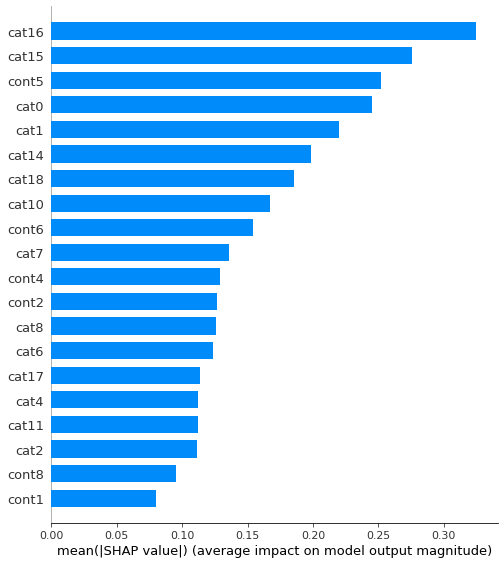

In [22]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [17]:
submission = submit(catboost_pipe)
submission.head()

Learning rate set to 0.11767
0:	learn: 0.6139339	total: 295ms	remaining: 4m 54s
1:	learn: 0.5567925	total: 560ms	remaining: 4m 39s
2:	learn: 0.5154786	total: 839ms	remaining: 4m 38s
3:	learn: 0.4828273	total: 1.09s	remaining: 4m 31s
4:	learn: 0.4588615	total: 1.33s	remaining: 4m 25s
5:	learn: 0.4406216	total: 1.58s	remaining: 4m 21s
6:	learn: 0.4269822	total: 1.8s	remaining: 4m 15s
7:	learn: 0.4167466	total: 2.04s	remaining: 4m 13s
8:	learn: 0.4081431	total: 2.31s	remaining: 4m 14s
9:	learn: 0.4010793	total: 2.57s	remaining: 4m 14s
10:	learn: 0.3956042	total: 2.81s	remaining: 4m 12s
11:	learn: 0.3911239	total: 3.12s	remaining: 4m 16s
12:	learn: 0.3877442	total: 3.41s	remaining: 4m 18s
13:	learn: 0.3842181	total: 3.7s	remaining: 4m 20s
14:	learn: 0.3813668	total: 3.97s	remaining: 4m 20s
15:	learn: 0.3791249	total: 4.24s	remaining: 4m 20s
16:	learn: 0.3769691	total: 4.5s	remaining: 4m 19s
17:	learn: 0.3751698	total: 4.77s	remaining: 4m 20s
18:	learn: 0.3735114	total: 5.03s	remaining: 4m 

158:	learn: 0.3464729	total: 44s	remaining: 3m 52s
159:	learn: 0.3464194	total: 44.2s	remaining: 3m 52s
160:	learn: 0.3463399	total: 44.6s	remaining: 3m 52s
161:	learn: 0.3462454	total: 44.8s	remaining: 3m 51s
162:	learn: 0.3461603	total: 45.1s	remaining: 3m 51s
163:	learn: 0.3460737	total: 45.4s	remaining: 3m 51s
164:	learn: 0.3460254	total: 45.6s	remaining: 3m 50s
165:	learn: 0.3459591	total: 45.9s	remaining: 3m 50s
166:	learn: 0.3458915	total: 46.1s	remaining: 3m 50s
167:	learn: 0.3458286	total: 46.4s	remaining: 3m 49s
168:	learn: 0.3457772	total: 46.7s	remaining: 3m 49s
169:	learn: 0.3457172	total: 47s	remaining: 3m 49s
170:	learn: 0.3456445	total: 47.3s	remaining: 3m 49s
171:	learn: 0.3455899	total: 47.6s	remaining: 3m 48s
172:	learn: 0.3455163	total: 47.8s	remaining: 3m 48s
173:	learn: 0.3454366	total: 48.1s	remaining: 3m 48s
174:	learn: 0.3453928	total: 48.4s	remaining: 3m 48s
175:	learn: 0.3453480	total: 48.7s	remaining: 3m 48s
176:	learn: 0.3452393	total: 49s	remaining: 3m 47s

312:	learn: 0.3387062	total: 1m 28s	remaining: 3m 13s
313:	learn: 0.3386585	total: 1m 28s	remaining: 3m 13s
314:	learn: 0.3386060	total: 1m 28s	remaining: 3m 12s
315:	learn: 0.3385702	total: 1m 28s	remaining: 3m 12s
316:	learn: 0.3385564	total: 1m 29s	remaining: 3m 12s
317:	learn: 0.3384815	total: 1m 29s	remaining: 3m 12s
318:	learn: 0.3384352	total: 1m 29s	remaining: 3m 11s
319:	learn: 0.3384091	total: 1m 30s	remaining: 3m 11s
320:	learn: 0.3384024	total: 1m 30s	remaining: 3m 11s
321:	learn: 0.3383668	total: 1m 30s	remaining: 3m 11s
322:	learn: 0.3383482	total: 1m 31s	remaining: 3m 10s
323:	learn: 0.3383204	total: 1m 31s	remaining: 3m 10s
324:	learn: 0.3382656	total: 1m 31s	remaining: 3m 10s
325:	learn: 0.3382148	total: 1m 31s	remaining: 3m 10s
326:	learn: 0.3381692	total: 1m 32s	remaining: 3m 9s
327:	learn: 0.3381036	total: 1m 32s	remaining: 3m 9s
328:	learn: 0.3380933	total: 1m 32s	remaining: 3m 9s
329:	learn: 0.3380678	total: 1m 33s	remaining: 3m 8s
330:	learn: 0.3380271	total: 1m 

466:	learn: 0.3334386	total: 2m 12s	remaining: 2m 31s
467:	learn: 0.3333995	total: 2m 13s	remaining: 2m 31s
468:	learn: 0.3333756	total: 2m 13s	remaining: 2m 31s
469:	learn: 0.3333504	total: 2m 13s	remaining: 2m 30s
470:	learn: 0.3333279	total: 2m 14s	remaining: 2m 30s
471:	learn: 0.3333040	total: 2m 14s	remaining: 2m 30s
472:	learn: 0.3332709	total: 2m 14s	remaining: 2m 29s
473:	learn: 0.3332394	total: 2m 14s	remaining: 2m 29s
474:	learn: 0.3332190	total: 2m 15s	remaining: 2m 29s
475:	learn: 0.3332044	total: 2m 15s	remaining: 2m 29s
476:	learn: 0.3331749	total: 2m 15s	remaining: 2m 28s
477:	learn: 0.3331543	total: 2m 16s	remaining: 2m 28s
478:	learn: 0.3331179	total: 2m 16s	remaining: 2m 28s
479:	learn: 0.3330908	total: 2m 16s	remaining: 2m 28s
480:	learn: 0.3330657	total: 2m 16s	remaining: 2m 27s
481:	learn: 0.3330401	total: 2m 17s	remaining: 2m 27s
482:	learn: 0.3329994	total: 2m 17s	remaining: 2m 27s
483:	learn: 0.3329717	total: 2m 17s	remaining: 2m 26s
484:	learn: 0.3329543	total:

619:	learn: 0.3292645	total: 2m 57s	remaining: 1m 48s
620:	learn: 0.3292324	total: 2m 57s	remaining: 1m 48s
621:	learn: 0.3292110	total: 2m 57s	remaining: 1m 47s
622:	learn: 0.3291816	total: 2m 57s	remaining: 1m 47s
623:	learn: 0.3291460	total: 2m 58s	remaining: 1m 47s
624:	learn: 0.3291253	total: 2m 58s	remaining: 1m 47s
625:	learn: 0.3291133	total: 2m 58s	remaining: 1m 46s
626:	learn: 0.3291046	total: 2m 59s	remaining: 1m 46s
627:	learn: 0.3290966	total: 2m 59s	remaining: 1m 46s
628:	learn: 0.3290463	total: 2m 59s	remaining: 1m 46s
629:	learn: 0.3290121	total: 3m	remaining: 1m 45s
630:	learn: 0.3289780	total: 3m	remaining: 1m 45s
631:	learn: 0.3289421	total: 3m	remaining: 1m 45s
632:	learn: 0.3289134	total: 3m	remaining: 1m 44s
633:	learn: 0.3288842	total: 3m 1s	remaining: 1m 44s
634:	learn: 0.3288687	total: 3m 1s	remaining: 1m 44s
635:	learn: 0.3288551	total: 3m 1s	remaining: 1m 44s
636:	learn: 0.3288180	total: 3m 2s	remaining: 1m 43s
637:	learn: 0.3287717	total: 3m 2s	remaining: 1m

772:	learn: 0.3255329	total: 3m 41s	remaining: 1m 5s
773:	learn: 0.3255193	total: 3m 42s	remaining: 1m 4s
774:	learn: 0.3254784	total: 3m 42s	remaining: 1m 4s
775:	learn: 0.3254616	total: 3m 42s	remaining: 1m 4s
776:	learn: 0.3254436	total: 3m 42s	remaining: 1m 3s
777:	learn: 0.3254106	total: 3m 43s	remaining: 1m 3s
778:	learn: 0.3253873	total: 3m 43s	remaining: 1m 3s
779:	learn: 0.3253469	total: 3m 43s	remaining: 1m 3s
780:	learn: 0.3253368	total: 3m 44s	remaining: 1m 2s
781:	learn: 0.3253022	total: 3m 44s	remaining: 1m 2s
782:	learn: 0.3252735	total: 3m 44s	remaining: 1m 2s
783:	learn: 0.3252558	total: 3m 44s	remaining: 1m 1s
784:	learn: 0.3252238	total: 3m 45s	remaining: 1m 1s
785:	learn: 0.3251898	total: 3m 45s	remaining: 1m 1s
786:	learn: 0.3251711	total: 3m 45s	remaining: 1m 1s
787:	learn: 0.3251384	total: 3m 46s	remaining: 1m
788:	learn: 0.3251233	total: 3m 46s	remaining: 1m
789:	learn: 0.3251210	total: 3m 46s	remaining: 1m
790:	learn: 0.3250995	total: 3m 46s	remaining: 60s
791:

929:	learn: 0.3220854	total: 4m 26s	remaining: 20.1s
930:	learn: 0.3220593	total: 4m 27s	remaining: 19.8s
931:	learn: 0.3220345	total: 4m 27s	remaining: 19.5s
932:	learn: 0.3219987	total: 4m 27s	remaining: 19.2s
933:	learn: 0.3219549	total: 4m 27s	remaining: 18.9s
934:	learn: 0.3219481	total: 4m 28s	remaining: 18.6s
935:	learn: 0.3219162	total: 4m 28s	remaining: 18.4s
936:	learn: 0.3218996	total: 4m 28s	remaining: 18.1s
937:	learn: 0.3218753	total: 4m 29s	remaining: 17.8s
938:	learn: 0.3218541	total: 4m 29s	remaining: 17.5s
939:	learn: 0.3218311	total: 4m 29s	remaining: 17.2s
940:	learn: 0.3218154	total: 4m 30s	remaining: 16.9s
941:	learn: 0.3217943	total: 4m 30s	remaining: 16.6s
942:	learn: 0.3217678	total: 4m 30s	remaining: 16.4s
943:	learn: 0.3217616	total: 4m 30s	remaining: 16.1s
944:	learn: 0.3217476	total: 4m 31s	remaining: 15.8s
945:	learn: 0.3217436	total: 4m 31s	remaining: 15.5s
946:	learn: 0.3217314	total: 4m 31s	remaining: 15.2s
947:	learn: 0.3217224	total: 4m 32s	remaining:

,id,target
0,5,0.140137
1,6,0.395102
2,8,0.015622
3,9,0.217600
4,11,0.140418


In [ ]:
submission.to_csv('submission_catboost_default.csv', index=False)

## Default xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(n_jobs=-2, eval_metric='auc', use_label_encoder=False)
from categorical_transform import IntegerCategoricalTransform
from sklearn.pipeline import Pipeline
xgb_pipe = Pipeline([('label encode',IntegerCategoricalTransform(cat_cols=cat_cols)),('xgboost', xgb)])

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(xgb_pipe, X=x_train, y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

In [ ]:
scores

In [ ]:
scores['test_score'].mean()

In [ ]:
submission = submit(xgb_pipe)
submission.head()

In [ ]:
submission.to_csv('submission_xgboost_default.csv', index=False)

## Default xgboost one hot encoded

In [35]:
from xgboost import XGBClassifier

In [36]:
xgb = XGBClassifier(n_jobs=-2, eval_metric='auc', use_label_encoder=False)
from categorical_transform import IntegerCategoricalTransform, OneHotTransform
from sklearn.pipeline import Pipeline
xgb_pipe = Pipeline([('label encode',IntegerCategoricalTransform(cat_cols=cat_cols)),
                     ('one hot transform',OneHotTransform()),
                     ('xgboost', xgb)])

In [37]:
from sklearn.model_selection import cross_validate
scores = cross_validate(xgb_pipe, X=x_train, y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

In [38]:
scores

{'fit_time': array([21.68744349, 21.77281475, 21.68598843, 21.73503137, 21.68976927]),
 'score_time': array([0.15446925, 0.15450549, 0.16226077, 0.16199064, 0.16181922]),
 'test_score': array([0.88901013, 0.88852074, 0.88928015, 0.88613496, 0.89121971]),
 'train_score': array([0.91336996, 0.9133477 , 0.91382637, 0.91407788, 0.91329402])}

In [39]:
scores['test_score'].mean()

0.8888331377137002

## Default xgboost one hot encoded, filtered

In [30]:
from xgboost import XGBClassifier

In [31]:
xgb = XGBClassifier(n_jobs=-2, eval_metric='auc', use_label_encoder=False)
from categorical_transform import IntegerCategoricalTransform, OneHotTransform
from sklearn.pipeline import Pipeline
xgb_pipe = Pipeline([('label encode',IntegerCategoricalTransform(cat_cols=cat_cols, min_data_portion=0.005)),
                     ('one hot transform',OneHotTransform()),
                     ('xgboost', xgb)])

In [32]:
from sklearn.model_selection import cross_validate
scores = cross_validate(xgb_pipe, X=x_train, y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

In [33]:
scores

{'fit_time': array([21.79947519, 21.65842152, 21.77025104, 21.78557301, 21.77489018]),
 'score_time': array([0.15921426, 0.15126276, 0.1514194 , 0.15140057, 0.15157747]),
 'test_score': array([0.88592565, 0.89090844, 0.88981494, 0.88943366, 0.88809497]),
 'train_score': array([0.91378675, 0.91340863, 0.91397606, 0.91474728, 0.91459816])}

In [34]:
scores['test_score'].mean()

0.8888355318596901

# Default categorical naive Bayes

In [64]:
from sklearn.naive_bayes import CategoricalNB

In [65]:
catnb = CategoricalNB()
from categorical_transform import NonNegativeIntegerCategoricalTransform
from sklearn.pipeline import Pipeline
catnb_pipe = Pipeline([('label encode',NonNegativeIntegerCategoricalTransform(cat_cols=cat_cols)),
                     ('catnb', catnb)])

In [66]:
from sklearn.model_selection import cross_validate
scores = cross_validate(catnb_pipe, X=x_train[cat_cols], y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

In [67]:
scores

{'fit_time': array([0.72551537, 0.70478535, 0.72354698, 0.70451069, 0.72440529]),
 'score_time': array([0.12254548, 0.12263012, 0.12210131, 0.12213039, 0.1220479 ]),
 'test_score': array([0.86880803, 0.86619198, 0.8651782 , 0.86648196, 0.86380629]),
 'train_score': array([0.86603298, 0.8663199 , 0.86659833, 0.8664273 , 0.86708366])}

In [68]:
scores['test_score'].mean()

0.8660932941298558

# Mixed naive Bayes

In [69]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

In [132]:
import numpy as np
class MixedBayesClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_cols, cont_cols):
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.catnb = CategoricalNB()
        self.gaussnb = GaussianNB()
        
    def _get_cont_X(self, X):
        return X[self.cont_cols]
    
    def _get_cat_X(self, X):
        return X[self.cat_cols]
    
    def fit(self, X, y):
        self.catnb.fit(self._get_cat_X(X), y)
        self.gaussnb.fit(self._get_cont_X(X), y)

    def predict_proba(self, X):
        log_prior = self.catnb.class_log_prior_
        jll_nb = self.catnb._joint_log_likelihood(self._get_cat_X(X).values)
        jll_gauss = self.gaussnb._joint_log_likelihood(self._get_cont_X(X).values)
        jll = jll_nb + jll_gauss - log_prior
        proba = np.exp(jll)
        sumso = np.sum(proba, axis = 1, keepdims = True) 
        return proba/sumso

In [133]:
mixed_nb = MixedBayesClassifier(cat_cols, cont_cols)
from categorical_transform import NonNegativeIntegerCategoricalTransform
from sklearn.pipeline import Pipeline
mixednb_pipe = Pipeline([('label encode',NonNegativeIntegerCategoricalTransform(cat_cols=cat_cols)),
                     ('catnb', mixed_nb)])

In [134]:
from sklearn.model_selection import cross_validate
scores = cross_validate(mixednb_pipe, X=x_train, y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

In [135]:
scores

{'fit_time': array([0.72657013, 0.72087049, 0.72114253, 0.72121239, 0.72184086]),
 'score_time': array([0.12797403, 0.12782145, 0.12763405, 0.12737489, 0.12780213]),
 'test_score': array([0.86635505, 0.86666463, 0.86756273, 0.869206  , 0.86922514]),
 'train_score': array([0.8685273 , 0.86837553, 0.86816831, 0.86784476, 0.8678119 ])}

In [136]:
scores['test_score'].mean()

0.8678027095258036

## Stacking simple models

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
cl = StackingClassifier(estimators = [('lgbm', lightgbm_pipe), 
                                      ('catboost', catboost_pipe),
                                      ('xgboost', xgb_pipe)
                                      ], verbose=1)

In [ ]:
cl.fit(x_train, y_train)

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(cl, X=x_train, y=y_train, cv=kfold, return_train_score = True,
                         scoring='roc_auc')

In [ ]:
scores

In [ ]:
scores['test_score'].mean()

In [ ]:
submission = submit(cl)
submission.head()

In [ ]:
submission.to_csv('submission_stack_default.csv', index=False)

## Lightgbm Optuna

In [ ]:
import lightgbm
x_train_cat = x_train.copy()
for cat in cat_cols:
    x_train_cat[cat] = x_train_cat[cat].astype("category")
data = lightgbm.Dataset(x_train_cat, label=y_train)

In [ ]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import KFold
params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": 0,
        "boosting_type": "gbdt",
    }

tuner = lgb.LightGBMTunerCV(
    params, data, time_budget=60*60, folds=KFold(n_splits=5)
)

tuner.run()

In [ ]:
tuner.best_score

In [ ]:
tuner.best_params

In [ ]:
lightgbm_tuned_pipe = Pipeline([("trans", CategoricalTransform(cat_cols)),
                          ("lgbm", LGBMClassifier(n_jobs=-2, **tuner.best_params))])

In [ ]:
submission = submit(lightgbm_tuned_pipe)
submission.head()

In [ ]:
submission.to_csv('submission_lightgbm_optuna.csv', index=False)

Worse than default catboost!